In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
import numpy as np

Importing the data file (from Hongyang's file), of a single simulation. The name of the file has the following structure: simState_typeExperiment_SampleID_numParticles_graphs.hdf5

In [2]:
#File containing information of sample 200
#f_200 = h5py.File('/Users/luisaorozco/Documents/Projects/GrainLearning/data/gnn_data/simState_drained_200_10000_graphs.hdf5', 'r')
#File containining all samples (200)
f_all = h5py.File('/Users/luisaorozco/Documents/Projects/GrainLearning/data/gnn_data/simState_path_sampling_5000_graphs.hdf5', 'r')

# Initial testing of the data (exploratory)

In [245]:
#contact parameters of the simulation of sample 200
contact_params = f_200['contact_params']
contact_params[:]

array([6.96000000e+10, 2.00000000e-01, 2.91456794e-01])

In [246]:
#contact parameters of the simulation of sample 200 retrieved from the big dataset
contact_params = f_all['200/contact_params']
contact_params[:]

array([6.96000000e+10, 2.00000000e-01, 2.91456794e-01])

In [247]:
#example for step 0 of sample 200
some_n_feats = f_200['0']['node_features'][:,5:8] #particle velocity
some_e_feats = f_200['0']['edge_features'][:,-3:] #the last 3 features for all nodes
pos_nodes = f_200['0']['node_features'][:,2:5] #position features
num_nodes = f_200['0']['input_features'][5]
num_nodes

10000.0

# Encoder: Definition of features embeddings
To be able to do operations between node and edges features, the dimensions of such tensors musht be the same. Thus, we can create an [*embedding*](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) that will encode *node_features* into a tensor of dimension *emb_dim* and another one for the *edge_features*.

In [248]:
class featuresEncoder(torch.nn.Module):
    def __init__(self,emb_dim,num_features):
        super(featuresEncoder, self).__init__()

        self.mlp = torch.nn.Linear(num_features,emb_dim,bias=True)
        self.mlp.reset_parameters()
        
    def forward(self, x):
        h_x = self.mlp(x)
        return h_x

# Creation of Graphs

## Single sample
Definition of a function that creates a dgl graph for a given step in the simulation.
It assigns the node and edge features to the nodes and edges of the graph.

In [3]:
def create_graph_dgl(f_sample, step):
    """
    Function that creates a graph given the dictionary of a sample and a step.
    We are creating one graph per time step.
    Returns a dglGraph homogeneous (single node type representing the particles)

    Arguments:
    ----------------
    f_sample : HDF5 file 
        Contains the information of a simulation for a given sample.
        The keys are numbers representing each step [0,200]
    step : int
        Index of the step [0,200]
    """
    assert isinstance(step, int), 'Argument of wrong type!'
    step_data = f_sample[f'time_sequence/{step}']
    sources = step_data['sources'][:]
    destinations = step_data['destinations'][:]
    num_nodes = len(step_data['node_features'])
    #input_params = step_data['macro_input_features'][:]
    
    graph = dgl.graph((sources, destinations), num_nodes=num_nodes)
    some_n_feats=step_data['node_features'][:]
    #WARNING! node features and edge features should have the same dimension to be able to make operations 

    graph.ndata['n_feats'] = torch.tensor(some_n_feats)
    #graph.theta = torch.tensor(input_params)

    return dgl.to_bidirected(graph,copy_ndata=True)

In [6]:
graph_0 = create_graph_dgl(f_all['0_7'],100)
print(type(graph_0))

<class 'dgl.heterograph.DGLHeteroGraph'>


In [7]:
#test out WARNING! node features and edge features should have 
#the same dimension to be able to make operations with edges and nodes features
graph_0.ndata['n_feats']
#graph_0.apply_edges(dgl.function.u_add_e('n_feats', 'e_feats', 'm'))
graph_0.theta_2 = [1,2,3] #adding a graph attribute
graph_0.theta_2
graph_0.ntypes

['_N']

About **graph level features** see this in [dgl discuss forum](https://discuss.dgl.ai/t/graph-level-features/1974):

*Option 1:* Store the graph level features in a special type of node. -> heterogeneous graph with different node types

*Option 2:* Store the graph level features in a separate tensor. (This seems complicated to handle when shuffling the data.)

*Option 3:* Store the graph level features as an attribute of the object DGLgraph

#### *Option 1*

In [4]:
def create_graph_dgl_heterogeneous(f_sample, step, num_nodes=10_000):
    """
    Function that creates a graph given the dictionary of a sample and an step.
    We are creating one graph per time step.
    In this graph we have 2 node types 'particle' and 'contact_params'.
    the second is a single node that carries the tensor with the 
    contact parameters.

    Arguments:
    ----------------
    f_sample : HDF5 file or HDF5 group
        Contains the information of a simulation for a given sample.
        The keys are numbers representing each step [0,200]
    step : int
        Index of the step [0,200]
    num_nodes : int
        number of particles, this could also be retrieved from 'input_features' of each step.
    """
    assert isinstance(step, int), 'Argument of wrong type!'
    step_data = f_sample[f'time_sequence/{step}']
    sources = torch.tensor(step_data['sources'][:])
    destinations = torch.tensor(step_data['destinations'][:])
    num_nodes = len(step_data['node_features'])
    #input_params = np.concatenate((step_data['other_features'][:],step_data['macro_input_features'][:]))
    input_params = step_data['macro_input_features'][:]
    #creating the data of the graph with nodes => particles
    data_dict = {
        #n_type source, e_type, n_stype dest:(1D tensor node source ID, 1D tensor node dest ID)
        ('particle','contact','particle'):(sources,destinations)
    }
    #Graph creation. adding a special node type for input_features
    graph = dgl.heterograph(data_dict,
                            num_nodes_dict={'particle':num_nodes,'theta':1,'macro':1})
    
    #Retrieve nodes and edge features
    some_n_feats=step_data['node_features'][:] #all node features
    #Assign features to nodes
    graph.nodes['particle'].data['n_feats'] = torch.tensor(some_n_feats)
    #graph.nodes['theta'].data['theta_params'] = torch.tensor([input_params]) 
    #tensor of size [1,len(input_params)]
    
    return dgl.to_bidirected(graph,copy_ndata=True)

In [148]:
graph_hetero = create_graph_dgl_heterogeneous(f_all['5_2'],1)
graph_hetero.ntypes
graph_hetero.etypes
#To get the data:
#graph_hetero.nodes['theta'].data['theta_params'] #This returns a tensor
#graph_hetero.ndata['theta_params'] #This returns a dict. Only possible if the feature is of a single type
#graph_hetero.srcdata['position'] #This returns a dict. Only possible if the feature is of a single type
#Graph operations
graph_hetero.update_all(dgl.function.copy_u('n_feats','m'),dgl.function.mean('m','h_avg'))

Loop to create `graphs_list`, containing one graph per simulation step for a given sample.

In [5]:
def create_graphs_dgl_of_sample(f_sample,homogeneous=True):
    """
    Function that creates a graph given the dictionary of a sample and an step.
    We are creating one graph per time step.

    Arguments:
    ----------------
    f_sample : HDF5 group 
        Contains the information of a simulation for a given sample.
    homogeneous : Bool
        True (default) if generating homogeneous graphs single node type (particles)
        False for having a graph with more node types in which the graph-level features would be stored
    """
    num_steps = f_sample['metadata/num_steps'][()] #[()] is needed because is a scalar dataspace
    strain_rate = torch.tensor([f_sample['metadata/compressive_strain_rate'][()]])
    initial_friction = torch.tensor([f_sample['metadata/initial_friction'][()]])
    pressure = torch.tensor([f_sample['metadata/pressure'][()]])
    shear_strain_rate = torch.tensor([f_sample['metadata/shear_strain_rate'][()]])
    graphs_sample = [] #list of graphs of sample f
    
    for i in range(num_steps - 2): #We don't create a graph for the last step
        #position_next = f_sample[str(i+1)]['node_features'][:,2:5]
        velocity_next = f_sample[f'time_sequence/{i+1}/node_features'][:,3:6]
        macro = f_sample[f'time_sequence/{i+1}/macro_output_features'] #stress
        inputs_this = torch.tensor(f_sample[f'time_sequence/{i}/macro_input_features']) #strain this t
        inputs_next = torch.tensor(f_sample[f'time_sequence/{i+1}/macro_input_features']) #strain next t
        delta_T = torch.tensor([f_sample[f'time_sequence/{i+1}/time'][0]-f_sample[f'time_sequence/{i}/time'][0]])
        theta = np.concatenate((inputs_this,inputs_next,delta_T,strain_rate,initial_friction,pressure,shear_strain_rate))
        if homogeneous:
            graph_i = create_graph_dgl(f_sample,i)
            #Labels -> Node features
            graph_i.ndata['label'] = torch.tensor(velocity_next)
            graph_i.label_macro = torch.tensor(macro)
            graph_i.theta = torch.tensor(theta)
        else:
            graph_i = create_graph_dgl_heterogeneous(f_sample,i)
            graph_i.nodes['particle'].data['label'] = torch.tensor(velocity_next)
            graph_i.nodes['macro'].data['label_macro'] = torch.tensor([macro])
            graph_i.nodes['theta'].data['theta_params'] = torch.tensor([theta])
            
        #graphs_sample.append(dgl.to_bidirected(graph_i,copy_ndata=True))
        graphs_sample.append(graph_i)
    
    return graphs_sample

## Multiple samples

In [6]:
list_g_i = create_graphs_dgl_of_sample(f_all['5_2'],homogeneous =False)
type(list_g_i[1])

/var/folders/ls/dj0bf91x7715kphjd6dghv0w0000gn/T/ipykernel_45638/3031097362.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1647804326539/work/torch/csrc/utils/tensor_new.cpp:210.)
  graph_i.nodes['theta'].data['theta_params'] = torch.tensor([theta])


dgl.heterograph.DGLHeteroGraph

In [12]:
list_g_i[80].nodes['theta'].data['theta_params'].size(dim=1)
len(list_g_i[80].nodes['theta'].data['theta_params'])

1

### (A) Data stored structurally in a tensor of fixed dimensions

In [67]:
#creating a tensor (n_sample x n_step) containing a graph per step of each sample
tensor_data = np.array([])
for sample_id in f_all:
    if f_all[f'{sample_id}/num_steps'][()] == 201: #only considering samples that have 200 steps
        graphs_sample_i = create_graphs_dgl_of_sample(f_all[f'{sample_id}'])
        #Staking the lists 2 axis: samples, steps
        if len(tensor_data)==0: tensor_data = graphs_sample_i
        else: tensor_data = np.vstack((tensor_data,graphs_sample_i))

KeyError: "Unable to open object (object 'num_steps' doesn't exist)"

In [70]:
#torch.tensor(tensor_data) #this is not supported because the elements are graphs (objects), not a common python type

In [115]:
len(tensor_data)

12

### (B) Data stored unstructurally in a list (samples) of lists (steps)

In [301]:
#creating a list of samples with variable step number
unstructured_data = []
for sample_id in f_all:
    graphs_sample_i = create_graphs_dgl_of_sample(f_all[f'{sample_id}'])
    if len(graphs_sample_i)>0: unstructured_data.append(graphs_sample_i)

### (C) Data stored as a list of graphs
Samples and steps might be combined thus, the labels, contact params and input parameters should be stored at the graph ```homogeneous=False```

In [6]:
list_graphs = []
for i,sample_id in enumerate(f_all):
    if i < len(f_all)-1:
        graphs_sample_i = create_graphs_dgl_of_sample(f_all[sample_id],homogeneous=False)
        list_graphs.extend(graphs_sample_i)

/var/folders/ls/dj0bf91x7715kphjd6dghv0w0000gn/T/ipykernel_48452/3031097362.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1647804326539/work/torch/csrc/utils/tensor_new.cpp:210.)
  graph_i.nodes['theta'].data['theta_params'] = torch.tensor([theta])


In [14]:
#homogeneous testing
list_graphs[3].theta

AttributeError: 'DGLHeteroGraph' object has no attribute 'theta'

In [242]:
#heterogeneous testing
t = list_graphs[3].nodes['theta'].data['theta_params']

In [245]:
n=list_graphs[3].nodes['particle'].data['n_feats']
r = torch.cat((t,n))

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 11 but got size 9 for tensor number 1 in the list.

In [8]:
#Set which type of data is going to be take into account: 
#unstructured (steps of variable size) or tensor (only considering samples with 200 steps) 
#or list_graphs (all steps and samples combined)
graph_data = list_graphs

# Data Split

### DGL

In [91]:
#Option 1: very basic in DGL
data_train, data_val, data_test = dgl.data.utils.split_dataset(
    graph_data,
    frac_list=[0.8, 0.1, 0.1],
    shuffle=True,random_state=25)

In [10]:
#Option 2 (Preferred): from DGL docs
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(graph_data)
#number of samples in train, validation and test dataset
num_train = int(num_examples * 0.8)
num_val = int(num_examples * 0.1)
num_test = num_examples - num_train - num_val

bs = 1 #batch size

train_sampler = SubsetRandomSampler(torch.arange(num_train))
val_sampler = SubsetRandomSampler(torch.arange(num_train, num_train+num_val))
test_sampler = SubsetRandomSampler(torch.arange(num_train+num_val, num_examples))

train_dataloader = GraphDataLoader(
    graph_data, sampler=train_sampler, batch_size=bs, drop_last=False)
val_dataloader = GraphDataLoader(
    graph_data, sampler=val_sampler, batch_size=bs, drop_last=False)
test_dataloader = GraphDataLoader(
    graph_data, sampler=test_sampler, batch_size=bs, drop_last=False)

If batch_size = 1 this technique is equivalent to the next one (pytorch). `GraphDataLoader` may combine the graphs is a batch in a single structure, but you can only take the advantages of having this feature if batch_size >1 

### pytorch
For a specific pytorch geometric function see [torch_geometric.loader.DataLoader](https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html?highlight=DataLoader) But this one doen't work with 'object' data types

In [ ]:
#TODO
def get_paths_to_data(file_hdf5):
    """
    Function that returns a list with tuples:
    (sample_id (str), step_id (int))
    Arguments:
    file_hdf5: and hdf5 file havign our structure {sample_id}/'time_sequence'/{time_step}
    """
    list_keys =[]
    for i,sample_id in enumerate(file_hdf5.keys()):
        if i < len(file_hdf5)-1: #getting rid of metadata (last one)
            str_acces_step = sample_id+'/time_sequence/'
            num_steps = file_hdf5[sample_id+'metadata/num_steps'][()]
            for j in range(num_steps):
                list_keys.append((sample_id,j))
    return list_keys

In [136]:
#option 1: very general Pytorch TODO
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

num_examples = len(list_keys)
#number of samples in train, validation and test dataset
num_train = int(num_examples * 0.8)
num_val = int(num_examples * 0.1)
num_test = num_examples - num_train - num_val

bs = 5 #batch size

train_sampler = SubsetRandomSampler(torch.arange(num_train))
val_sampler = SubsetRandomSampler(torch.arange(num_train, num_train+num_val))
test_sampler = SubsetRandomSampler(torch.arange(num_train+num_val, num_examples))

train_dataloader = DataLoader(
    graph_data, sampler=train_sampler, batch_size=bs, drop_last=False)
val_dataloader = DataLoader(
    graph_data, sampler=val_sampler, batch_size=bs, drop_last=False)
test_dataloader = DataLoader(
    graph_data, sampler=test_sampler, batch_size=bs, drop_last=False)

# Creation of GNN

## 1. A simple GNN

### GNN at the node level
We create this layer that is going to do the message passing and then prediction of each node feature as follows:
$$\mathbf{h}_i^{(l+1)} = \text{MLP_1}[ (1+\varepsilon) \cdot \mathbf{h}_i^{(l)} + \text{ReLU}\{W (\text{concat}(\sum_{j \in \mathcal{N}_i} \mathbf{h}_j^{l}, \theta_{DEM})+bias)\}]$$

In [169]:
class myGnn(nn.Module):
    def __init__(self,emb_dim,theta_dim):
        """
        This class implements a single GNN layer with node and edge features.
    
        Arguments
        ----------
        emb_dim : int
            Number of dimensions of the node embeding (features)
        theta_dim : int
            Number of dimensions of the theta parameters
        """
        super(myGnn, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 2*emb_dim), 
            #nn.BatchNorm1d(2*emb_dim), 
            nn.ReLU(), 
            nn.Linear(2*emb_dim, emb_dim)
        )
        self.linear = nn.Linear(emb_dim+theta_dim,emb_dim,bias=True)
        self.epsilon = nn.Parameter(torch.FloatTensor([0]))
        self.reset_parameters()
        
    def reset_parameters(self):
        """
        A method that defines how to re-initialize all the parameters of
        the model.
        """
        # MLP
        for layer in self.mlp:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        self.linear.reset_parameters()
        # epsilon
        nn.init.constant_(self.epsilon, 0.)
    
    def forward(self, g, x_node):
        """
        Applies the update equation, which includes edge features
        Arguments
        ----------
        g : DGLGraph
            The graph used for message passing
        x_node : Tensor
            The node features (i.e., velocity)
        """
        with g.local_scope():
            g.ndata['h'] = x_node
            g.update_all(dgl.function.copy_u('h', 'm'), dgl.function.sum('m', 'h_mp'))
            h_mp = g.ndata['h_mp']
            # Concatenation of node features and theta and passing it to the linear layer
            h_n = self.linear(torch.cat(h_mp, g.theta))
            h_n = F.relu(h_n)
            return self.mlp((1+self.epsilon) * x_node + h_n)

### GNN at the graph level
We create this model in which we will have several myGnn layers stacked

In [170]:
class model_gnn(nn.Module):
    def __init__(self, emb_dim, theta_dim, num_layers, add_bn=False, dropout=0):
        """
        Defines the architecture of the model.
        The `forward` method will define how to use the 
        layers created here.
        """
        super(model_gnn, self).__init__()
        
        self.num_layers = num_layers
        #batch normalization and droput
        self.add_bn = add_bn
        self.dropout = nn.Dropout(dropout)
        
        #Stacked layers
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(myGnn(emb_dim,theta_dim))
        
        self.reset_parameters()
        
    def reset_parameters(self):
        """
        A method that defines how to re-initialize all the parameters of
        the model.  This method will be invoked to start a new experiment,
        so it is important that all parameters are reset, or else there will 
        be an information leak between experiments.
        """
        for ly in self.layers:
            ly.reset_parameters()
        
    def forward(self, g):
        """
        Arguments
        ----------
        g : DGLGraph
            The graph used for message passing
        """
        h_node = g.ndata['n_feats']
        for i,ly in enumerate(self.layers[:-1]):
            with g.local_scope(): #So that we will not modify the graph
                h_node = ly(g, h_node)
                h_node = F.relu(h_node)
        return h_node

## 2. A GNN that handles heterogenous graph
### GNN at the node level

We create this layer that is going to do the message passing and then prediction of each node feature as follows:
$$\mathbf{h}_i^{(l+1)} = MLP_1 \left[ (1+\varepsilon) \cdot \mathbf{h}_i^{(l)} + MLP_2 \left( CONCAT\left\{ \sum_{j \in \mathcal{N}_i} \frac{\mathbf{h}_j^{(l)}}{\mathcal{N}_i}, \theta_{DEM} \right\} \right) \right]$$
Where $\theta_{DEM}$ is `input_params` like $\dot{\varepsilon},\sigma , \mu_0$. Note that in this model we do ***not consider*** edge features for the Message passing.

In [11]:
class myGnn_heterogeneous(nn.Module):
    def __init__(self,emb_dim,theta_dim,n_type_part,n_type_th):
        """
        This class implements a single GNN layer with node and edge features.
        Arguments
        ----------
        emb_dim : int
            Dimension of the node embedding (feature)
        theta_dim : int
            Dimension of the control parameters \theta
        n_type_part : str
            String identifier of the nodes representing particles
        n_type_th : str
            String identifier of the nodes representing theta 
            (control parameters of the experiment)
        """
        super(myGnn_heterogeneous, self).__init__()
        
        self.n_type_particles = n_type_part
        self.n_type_theta = n_type_th
        self.theta_size = theta_dim
        self.mlp_1 = nn.Linear(emb_dim,emb_dim,bias=True)
        self.mlp_2 = nn.Linear(emb_dim+theta_dim,emb_dim,bias=True)
        self.epsilon = nn.Parameter(torch.FloatTensor([0]))
        self.reset_parameters()
        
    def reset_parameters(self):
        """
        A method that defines how to re-initialize all the parameters of
        the model.
        """
        # MLP
        self.mlp_1.reset_parameters()
        self.mlp_2.reset_parameters()
        
        # epsilon
        nn.init.constant_(self.epsilon, 0.)
    
    def forward(self, g, x_node):
        """
        Applies the update equation, which includes edge features
        Arguments
        ----------
        g : DGLGraph heterogeneous
            The graph used for message passing
        x_node : Tensor
            The node features or embeddings (i.e., position)
        """
        theta = g.nodes[self.n_type_theta].data['theta_params']
        num_nodes_in_batch = g.nodes[self.n_type_particles].data['n_feats'].size(dim=0)
        bs = theta.size(dim=0)
        repeats = torch.ones(bs,dtype=int)*int(num_nodes_in_batch/bs)
        theta_repeated = torch.repeat_interleave(theta,repeats,dim=0)
        #we obtain a tensor of size (num_nodes,num_theta_params)
        with g.local_scope():
            # Store node features to 'h_n' key in g.ndata
            g.nodes[self.n_type_particles].data['h_n'] = x_node
            # m-> message , h_avg -> aggregated message
            g.update_all(dgl.function.copy_u('h_n', 'm'), dgl.function.mean('m', 'h_avg'))
            h_avg = g.nodes[self.n_type_particles].data['h_avg']
            cat_vector = torch.cat((h_avg,theta_repeated),dim=-1)
            h_n = self.mlp_2(cat_vector.float())
            h_self = ((1+ self.epsilon) * x_node)
            return self.mlp_1(h_self + h_n)

In [12]:
class model_gnn_heterogeneous(nn.Module):
    def __init__(self,emb_dim,theta_dim,out_dim,
                  num_layers,n_type_part,n_type_th,add_bn=False,dropout=0):
        """
        Defines the architecture of the model.
        Arguments
        ----------
        emb_dim : int
            Dimension of the node embedding (feature)
        theta_dim : int
            Dimension of the control parameters \theta
        out_dim : int
            Dimension of the output
        n_type_part : str
            String identifier of the nodes representing particles
        n_type_th : str
            String identifier of the nodes representing theta 
            (control parameters of the experiment)
        """
        super(model_gnn_heterogeneous, self).__init__()
        
        self.num_layers = num_layers
        self.n_type_particles = n_type_part
        self.n_type_theta = n_type_th
        
        #batch normalization and droput
        self.add_bn = add_bn
        self.dropout = nn.Dropout(dropout)
        
        #Stacked layers
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(myGnn_heterogeneous(emb_dim,theta_dim,n_type_part,n_type_th))
            
        self.layers.append(nn.Linear(emb_dim,out_dim))
        self.reset_parameters()
        
    def reset_parameters(self):
        """
        Defines how to re-initialize all parameters of the model.
        This method will be invoked to start a new experiment,
        so it is important that all parameters are reset, or else there will 
        be an information leak between experiments.
        """
        for ly in self.layers:
            ly.reset_parameters()
        
    def forward(self, g):
        """
        Arguments
        ----------
        g : DGLGraph heterogeneous
            The graph used for message passing
        """
        h_node = g.nodes[self.n_type_particles].data['n_feats']
        for ly in self.layers[:-1]:
            with g.local_scope(): #So that we will not modify the graph
                h_node = ly(g, h_node)
                h_node = F.relu(h_node)
        return self.layers[-1](h_node)

# Creation of the model
<a id='creation_model'></a>

In [13]:
#model parameters definition
num_layers = 2
node_types = graph_data[0].ntypes
if len(node_types)>1 : #heterogeneous graph
    node_type_macro, node_type_particles, node_type_theta = node_types
    emb_dim = graph_data[0].nodes[node_type_particles].data['n_feats'].size(dim=1)
    theta_dim = graph_data[0].nodes[node_type_theta].data['theta_params'].size(dim=1)
    out_feats = graph_data[0].nodes[node_type_particles].data['label'].size(dim=1)
    model = model_gnn_heterogeneous(emb_dim,theta_dim,out_feats,num_layers,node_type_particles,node_type_theta)
else: #homogeneous graph
    emb_dim = graph_data[0].ndata['n_feats'].size(dim=1)
    theta_dim = graph_data[0].theta.size(dim=0)
    out_feats = graph_data[0].ndata['label'].size(dim=1)+graph_data[0].label_macro.size(dim=0)
    model = model_gnn(emb_dim,theta_dim,out_feats,num_layers)


## 3. Model of Brandstetter et al. 

In [ ]:
#TODO

# Model training
The following steps will be carried up:
1. Definition of the optimizer
2. Definition of the loss function
3. Definition of the trainning loop

### Optimizer definition

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

### Loss Function

In [ ]:
loss_fn = torch.nn.L1Loss()
#loss_fn = torch.nn.mse_loss()

### The training Loop proposed by [Pytorch](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)
This is a very basic template

In [17]:
def get_labels_from_graphList(list_graphs):
    """
    Returns the labels of a graph
    Arguments:
    --------------
    list_graphs : graph
        Super graph containing batch_size DGLGraphs
    """
    node_types = list_graphs.ntypes
    if len(node_types)>1: #heterogeneous
        labels = list_graphs.nodes[node_types[1]].data['label']
        labels_macro = list_graphs.nodes[node_types[0]].data['label_macro'].squeeze(dim=0)
    else: #homogeneous
        labels = list_graphs.ndata['label']
        labels_macro = list_graphs.label_macro
    return labels, labels_macro

In [ ]:
def train_one_epoch(model,epoch_index,loss_fn,training_loader,tb_writer=None):
    """
    Function to train an epoch, default pytorch using TensorBoard.
    Arguments:
    -----------------
        model : GNN model
        epoch_index: int
        loss_fn: 
            Loss function
        tb_writer: SummaryWriter (TensorBoard)
        training_loader: Data loader
    """
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, batch_graphs in enumerate(training_loader):
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(batch_graphs)
        
        #get the labels
        labels, labels_macro = get_labels_from_graphList(batch_graphs)
        
        # Compute features loss and its gradients
        loss = loss_fn(outputs, labels) #For the moment labels only node features
        loss.backward()
        #Compute macro loss and its gradients
        #loss_macro = loss_fn(outputs[3:], labels_macro)
        #loss_macro.backward()
        
        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            if (tb_writer==None): wandb.log({'Loss/train': last_loss,
                             'trainning step': tb_x})
            else: tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

**Per-Epoch Activity**
There are a couple of things we’ll want to do once per epoch:

* Perform validation by checking our relative loss on a set of data that was not used for training, and report this
* Save a copy of the model

Here, we’ll do our reporting in TensorBoard. During the training a folder will be creatied inside runs. To visualize them open the folder containing runs and run `tensorboard --logdir=runs`, then copy `http://localhost:6006/` to your browser to open the tensorboard visualizer.

In [ ]:
def train_tensorboard(model,num_epochs,loss_fn,training_loader,validation_loader,tb_writer):
    best_vloss = 1_000_000.
    for epoch in range(num_epochs):
        print('EPOCH {}:'.format(epoch + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(model,epoch,loss_fn,training_loader,tb_writer=tb_writer)

        # We don't need gradients on to do reporting
        model.train(False)

        running_vloss = 0.0
        for i, vdata in enumerate(validation_loader):
            voutputs = model(vdata)
            vlabels, vlabels_macro = get_labels_from_graphList(vdata)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        tb_writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch)
        tb_writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
EPOCHS = 5

In [345]:
train_tensorboard(model,EPOCHS,loss_fn,train_dataloader,val_dataloader,writer)

EPOCH 1:
  batch 1000 loss: 0.6874793180823326
  batch 2000 loss: 0.6861921851038932
  batch 3000 loss: 0.6833268201947212
  batch 4000 loss: 0.6827743496894837
  batch 5000 loss: 0.6816953321099282
  batch 6000 loss: 0.6831414459347724
  batch 7000 loss: 0.6823037651181221
  batch 8000 loss: 0.6821828244924545
  batch 9000 loss: 0.6829529471993446
  batch 10000 loss: 0.6841480988264084
  batch 11000 loss: 0.6853966968059539
  batch 12000 loss: 0.6864752916097641
LOSS train 0.6864752916097641 valid 0.6797007322311401
EPOCH 2:
  batch 1000 loss: 0.68649784553051
  batch 2000 loss: 0.6822987530827522
  batch 3000 loss: 0.6818726670145988
  batch 4000 loss: 0.6866000335216522
  batch 5000 loss: 0.6844046101570129
  batch 6000 loss: 0.6814422015547752
  batch 7000 loss: 0.6851514179706574
  batch 8000 loss: 0.6843487210273743
  batch 9000 loss: 0.6830541912317276
  batch 10000 loss: 0.6842596131563187
  batch 11000 loss: 0.6832783486247063
  batch 12000 loss: 0.6853938121795654
LOSS train 

KeyboardInterrupt: 

# Training using wandb

In [ ]:
import wandb
wandb.init(project='GNN_initial_test') #start a run
config = wandb.config
wandb.watch(model)

In [ ]:
def train_wandb(model,num_epochs,loss_fn,training_loader,validation_loader):
    """
    Function to train a model, usign experiment tracking wandb.
    Arguments:
    -----------------
        model : GNN model
        num_epochs: int
        loss_fn: 
            Loss function
        training_loader: Data loader
        validation_loader: Data loader
    """
    best_vloss = 1_000_000.
    for epoch in range(num_epochs):
        print('EPOCH {}:'.format(epoch + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(model, epoch, loss_fn, training_loader)

        # We don't need gradients on to do reporting
        model.train(False)

        running_vloss = 0.0
        for i, vdata in enumerate(validation_loader):
            voutputs = model(vdata)
            vlabels, vlabels_macro = get_labels_from_graphList(vdata)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        wandb.log({'Training Loss' : avg_loss, 
                   'Validation Loss' : avg_vloss, 
                   'epoch': epoch},
                )

        # Track best performance, and save the best model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_best{}'.format(timestamp)
            torch.save(model.state_dict(), model_path)

In [21]:
train_wandb(model,5,loss_fn,train_dataloader,val_dataloader)

EPOCH 1:


/opt/homebrew/Caskroom/miniforge/base/envs/GrainLearning/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


  batch 1000 loss: 0.15496826105564832
  batch 2000 loss: 0.12373793717846274
  batch 3000 loss: 0.12284514275565743
  batch 4000 loss: 0.12386507965624333
  batch 5000 loss: 0.12447568797692657
  batch 6000 loss: 0.12517126007378102
  batch 7000 loss: 0.1271480363085866
  batch 8000 loss: 0.12534524934738875
  batch 9000 loss: 0.11943239637091756
  batch 10000 loss: 0.12406054601073264
  batch 11000 loss: 0.1254925480633974
  batch 12000 loss: 0.12396180425211788
  batch 13000 loss: 0.1261508788689971
  batch 14000 loss: 0.12399742457270622
  batch 15000 loss: 0.12615143145248295
  batch 16000 loss: 0.12694257579743862
  batch 17000 loss: 0.1256946885250509
  batch 18000 loss: 0.1232190890610218
  batch 19000 loss: 0.1219453156478703
  batch 20000 loss: 0.12264493888244032
  batch 21000 loss: 0.12337215861305595
  batch 22000 loss: 0.1265384682379663
  batch 23000 loss: 0.12764782214909792
  batch 24000 loss: 0.12391883159801365
  batch 25000 loss: 0.12176994782686233
  batch 26000 lo

### Trainning loop of Brandstetter et al.

In [ ]:
#TODO
#def training_loop(model,batch_size,optimizer,loss_fn):
    

# Loading a model
First define a model in: [Creation of the model](#creation_model)

In [14]:
#Run first cell defining the model
PATH = "./model_20220815_113137_1"
model.load_state_dict(torch.load(PATH))
model.eval()

model_gnn_heterogeneous(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): myGnn_heterogeneous(
      (mlp_1): Linear(in_features=9, out_features=9, bias=True)
      (mlp_2): Linear(in_features=20, out_features=9, bias=True)
    )
    (1): myGnn_heterogeneous(
      (mlp_1): Linear(in_features=9, out_features=9, bias=True)
      (mlp_2): Linear(in_features=20, out_features=9, bias=True)
    )
    (2): Linear(in_features=9, out_features=3, bias=True)
  )
)

## Plot model predictions on the test set

In [27]:
from matplotlib import pyplot as plt
def plot_predictions(test_loader):
    %matplotlib inline
    fig, ax = plt.subplots(1, 3)
    prediciton,label= ([] for _ in range(2))
    for i, test_data in enumerate(test_loader):
        if i>=1: break
        prediciton_i = model(test_data).detach().numpy()
        label_i, labels_macro = get_labels_from_graphList(test_data)
        label_i = label_i.detach().numpy()
        #print(prediciton_i[:,0].shape)
        #print(type(label_i[:,0]))
        for j in range(3):
            ax[j].plot(label_i[:,j],prediciton_i[:,j]) 
            #TODO check structure of labels and predictions
    
    #labels of the plot
    for j in range(3): 
        ax[j].set_xlabel('truth')
        ax[j].set_ylabel('prediction')
    plt.tight_layout()
    plt.show()

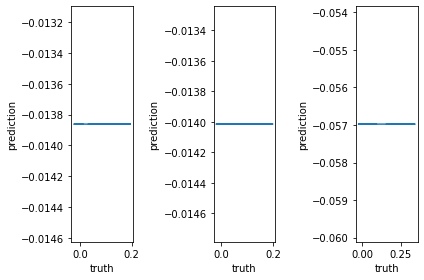

In [28]:
plot_predictions(test_dataloader)

In [31]:
next(iter(test_dataloader))
prediciton_i = model(next(iter(test_dataloader)))

In [32]:
prediciton_i

tensor([[-0.0139, -0.0140, -0.0570],
        [-0.0139, -0.0140, -0.0570],
        [-0.0139, -0.0140, -0.0570],
        ...,
        [-0.0139, -0.0140, -0.0570],
        [-0.0139, -0.0140, -0.0570],
        [-0.0139, -0.0140, -0.0570]], grad_fn=<AddmmBackward0>)